In [14]:
import os
import re
import numpy as np
import periodictable as pt
import matplotlib.pyplot as plt

from PIL import Image

BASEDIR = "/home/lachlan/CODEBASE/ReadoutXFM/"
TIFDIR = "data/processed_maps/zoe_25um/S1"
IMGBASE = "S1_25um_cali"
EXT='.tiff'
INITELEMENTS=['sum','Compton']

TRUE_ELEMENTS = []

for ptelement in pt.elements:
    TRUE_ELEMENTS.append(ptelement.symbol)



In [19]:
def get_elements(files):

    elements=[]
    keepfiles=[]    

    for fname in files:

        try:
            found=re.search('\-(\w+)\.', fname).group(1)
        except AttributeError:
            print(f"WARNING: no element found in {fname}")
            found=''
        finally:
            if found in TRUE_ELEMENTS:
                elements.append(found)
                keepfiles.append(fname)
            elif found in INITELEMENTS:
                elements.append(found)
                keepfiles.append(fname)
            else:
                print(f"WARNING: Unexpected element {found} not used")

    files = keepfiles
    if len(elements) == len(files):
        zipped = zip(elements, files)    
        zipped_sorted = sorted(zipped)

        elements = [elements for elements, files  in zipped_sorted]
        files = [files for elements, files in zipped_sorted]

    else:
        raise ValueError("mismatch between elements and files")
    

    
    """
    move sum, compton etc at start - does not change files, only elements
    
    for iidx, ivalue in enumerate(INITELEMENTS):
        for idx, value in enumerate(elements):
            if ivalue ==  value:
                elements.remove(ivalue)
        elements.insert(iidx,ivalue)            
    """


    return elements, files

In [90]:
"""
for f in files:
    im = Image.open(f)
    img = np.array(im)
"""

wdir = os.path.join(BASEDIR, TIFDIR)

files = [f for f in os.listdir(wdir) if f.endswith('.tiff')]

elements, files = get_elements(files)

filepaths = [os.path.join(wdir, file) for file in files ] 

#get file dimensions:

im = Image.open(os.path.join(wdir, filepaths[0]))
img = np.array(im)

dims = img.shape

maps=np.zeros((len(elements), dims[0], dims[1]), dtype=np.float32)

i=0
for f in filepaths:
    im = Image.open(f)
    img = np.array(im)
    #replace all negative values with 0
    img = np.where(img<0, 0, img)
    maps[i,:,:]=img/100000
    i+=1
    
maps.shape


(23, 580, 1150)

['Al', 'As', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Mo', 'Na', 'Ni', 'Rb', 'S', 'Si', 'Sr', 'Ti', 'V', 'Zn', 'Zr', 'sum']
Al
6.5793524 0.0


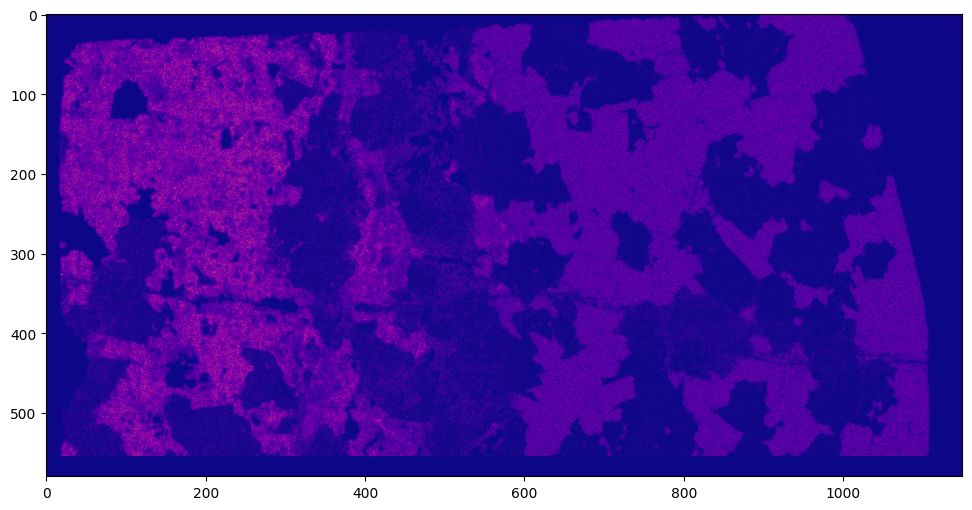

In [91]:
IDX=0

img = maps[IDX,:,:]

print(elements)
print(elements[IDX])
print(np.max(img), np.min(img))

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)

display = ax.imshow(img, cmap='plasma')

plt.show()